# [Home](https://citizen-shield.github.io/multi-method-protective-behaviour/)

## Using a toy dataset to better understand SHapley Additive exPlanations (SHAP)
Using a simple DecisionTreeRegressor and a Catboost Regressor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from jmspack.frequentist_statistics import correlation_analysis
from jmspack.utils import flatten, JmsColors
from jmspack.ml_utils import plot_decision_boundary

from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from catboost import CatBoostRegressor, Pool
import shap

In [2]:
shap.initjs()

In [3]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [4]:
df = (pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv")
      .dropna()
      # .pipe(lambda d: d[d["species"] != "Gentoo"])
      .sample(frac=0.2, random_state=42)
      )

In [5]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
30,Adelie,Dream,39.5,16.7,178.0,3250.0,FEMALE
317,Gentoo,Biscoe,46.9,14.6,222.0,4875.0,FEMALE
79,Adelie,Torgersen,42.1,19.1,195.0,4000.0,MALE
201,Chinstrap,Dream,49.8,17.3,198.0,3675.0,FEMALE
63,Adelie,Biscoe,41.1,18.2,192.0,4050.0,MALE


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 30 to 66
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            67 non-null     object 
 1   island             67 non-null     object 
 2   bill_length_mm     67 non-null     float64
 3   bill_depth_mm      67 non-null     float64
 4   flipper_length_mm  67 non-null     float64
 5   body_mass_g        67 non-null     float64
 6   sex                67 non-null     object 
dtypes: float64(4), object(3)
memory usage: 4.2+ KB


In [7]:
cors_df = correlation_analysis(data=df, check_norm=True)["summary"]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [8]:
cors_df[cors_df["p-value"] < 0.01].sort_values(by="r-value")

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
3,Pearson,bill_depth_mm,flipper_length_mm,-0.553100,1.211080e-06,True,67
4,Pearson,bill_depth_mm,body_mass_g,-0.410843,5.534923e-04,True,67
2,Pearson,bill_length_mm,body_mass_g,0.541522,2.223110e-06,True,67
1,Pearson,bill_length_mm,flipper_length_mm,0.585532,1.944275e-07,True,67
5,Pearson,flipper_length_mm,body_mass_g,0.892055,4.179934e-24,True,67


In [9]:
# feature_list = df.select_dtypes("float").columns.tolist()
feature_list = ["flipper_length_mm", "bill_length_mm"]
outcome = "species"
len(feature_list), outcome

(2, 'species')

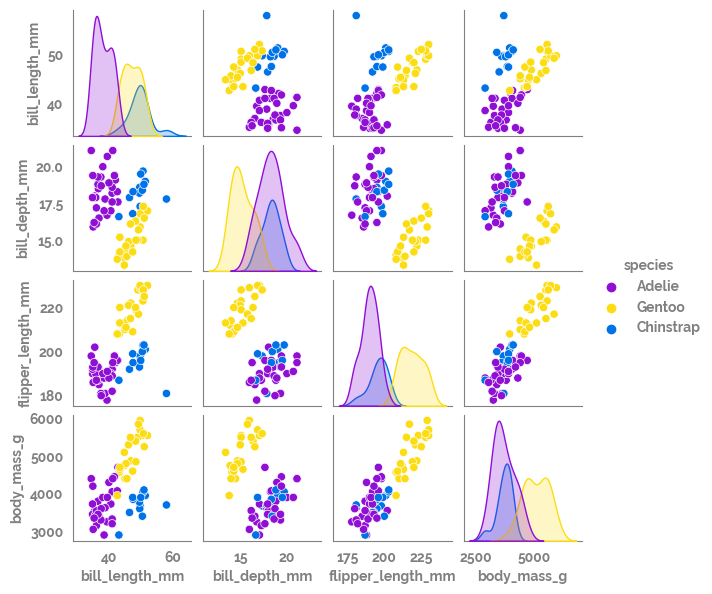

In [10]:
_ = sns.pairplot(data=df, hue=outcome, height=1.5)

In [11]:
df = df.assign(**{f"{outcome}_int": lambda d: d[outcome].astype("category").cat.codes})

In [12]:
train_idx = df.sample(frac=0.8, random_state=42).index.tolist()
test_idx = df.drop(train_idx, axis=0).index.tolist()

In [13]:
X_train = df.loc[train_idx, feature_list]
y_train = df.loc[train_idx, f"{outcome}_int"]

X_test = df.loc[test_idx, feature_list]
y_test = df.loc[test_idx, f"{outcome}_int"]

In [14]:
tree_model = DecisionTreeClassifier(criterion="gini", max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state = 100)
tree_model.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_depth=4, random_state=100)

In [15]:
df[[outcome, f"{outcome}_int"]].drop_duplicates().sort_values(by="species_int")

,species,species_int
30,Adelie,0
201,Chinstrap,1
317,Gentoo,2


In [16]:
class_names_list = df[[outcome, f"{outcome}_int"]].drop_duplicates().sort_values(by="species_int")[outcome].tolist()
class_names_list

['Adelie', 'Chinstrap', 'Gentoo']

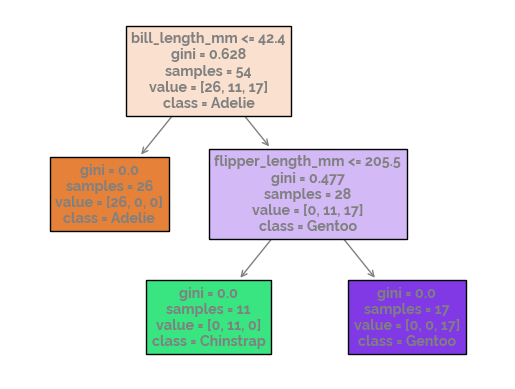

In [17]:
_ = plot_tree(tree_model, filled=True, class_names=class_names_list, 
              feature_names=feature_list, label="all", node_ids=False)

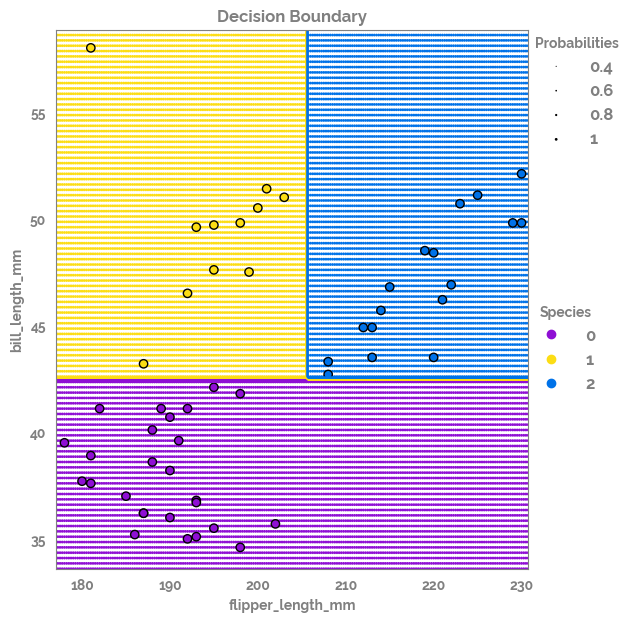

In [18]:
_ = plot_decision_boundary(X=X_train, y=y_train, clf=tree_model, 
                           title='Decision Boundary', 
                           legend_title = "Species", h=0.25, figsize=(7,7))

In [19]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=4, min_samples_leaf=1, min_samples_split=2, random_state = 100)
tree_model.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=4, random_state=100)

In [20]:
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)
shap_values

array([[-0.43518519,  0.60185185],
       [ 0.92592593,  0.24074074],
       [-0.60185185, -0.23148148],
       [-0.43518519,  0.60185185],
       [ 0.92592593,  0.24074074],
       [-0.07407407,  0.24074074],
       [ 0.92592593,  0.24074074],
       [-0.60185185, -0.23148148],
       [ 0.92592593,  0.24074074],
       [ 0.92592593,  0.24074074],
       [-0.60185185, -0.23148148],
       [-0.43518519,  0.60185185],
       [ 0.92592593,  0.24074074]])

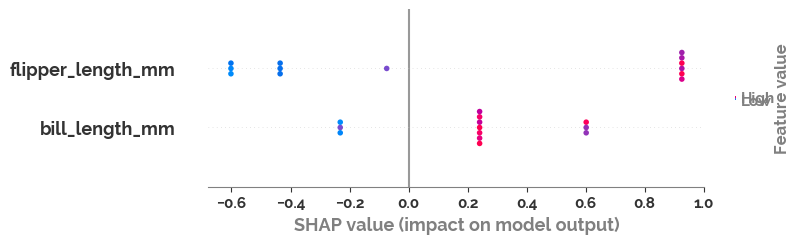

In [21]:
shap.summary_plot(shap_values, X_test)

In [22]:
shap_actual_df = pd.concat([pd.DataFrame(shap_values, columns=feature_list).melt(value_name="shap_data"),
pd.DataFrame(X_test.values, columns=feature_list).melt(value_name="actual_data").drop("variable", axis=1)], axis=1)
shap_actual_df.groupby("variable").apply(lambda d: d.sort_values(by="shap_data", ascending=False))

variable  shap_data  actual_data
variable                                                       
bill_length_mm    13     bill_length_mm   0.601852         42.9
                  16     bill_length_mm   0.601852         42.7
                  24     bill_length_mm   0.601852         50.0
                  14     bill_length_mm   0.240741         45.1
                  17     bill_length_mm   0.240741         49.1
                  18     bill_length_mm   0.240741         50.7
                  19     bill_length_mm   0.240741         47.5
                  21     bill_length_mm   0.240741         49.3
                  22     bill_length_mm   0.240741         45.4
                  25     bill_length_mm   0.240741         50.8
                  15     bill_length_mm  -0.231481         36.7
                  20     bill_length_mm  -0.231481         35.0
                  23     bill_length_mm  -0.231481         41.3
flipper_length_mm 1   flipper_length_mm   0.925926        210.0
                  4   flipper_length_mm   0.925926        228.0
                  6   flipper_length_mm   0.925926        209.0
                  8   flipper_length_mm   0.925926        217.0
                  9   flipper_length_mm   0.925926        211.0
                  12  flipper_length_mm   0.925926        228.0
                  5   flipper_length_mm  -0.074074        203.0
                  0   flipper_length_mm  -0.435185        196.0
                  3   flipper_length_mm  -0.435185        196.0
                  11  flipper_length_mm  -0.435185        196.0
                  2   flipper_length_mm  -0.601852        187.0
                  7   flipper_length_mm  -0.601852        190.0
                  10  flipper_length_mm  -0.601852        195.0

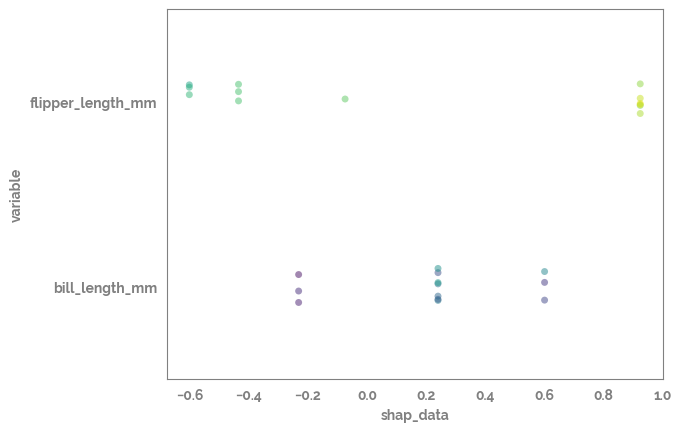

In [23]:
ax = sns.stripplot(data=shap_actual_df,
                  x="shap_data",
                  y="variable",
                  hue="actual_data",
                  order=shap_actual_df.groupby("variable").var()["shap_data"].sort_values(ascending=False).index.tolist(),
                  alpha=0.5,
                  palette="viridis")
_ = plt.legend([],[], frameon=False)

In [24]:
model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# train the model
_ = model.fit(X_train, y_train)

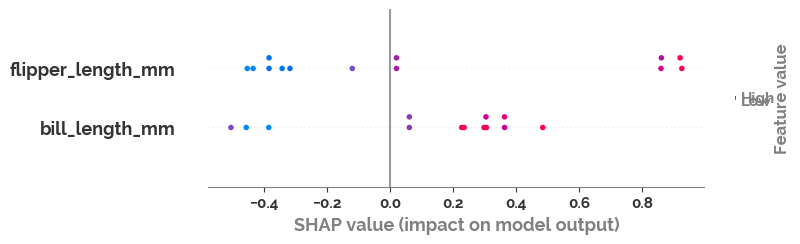

In [25]:
shap_values = model.get_feature_importance(Pool(X_test, label=y_test), type="ShapValues")

shap_values = shap_values[:,:-1]

_ = shap.summary_plot(shap_values, 
                                X_test.astype(int), 
                                feature_names=X_test.columns, 
                                max_display=X_test.shape[1],
                                show=True) 

In [26]:
shap_actual_df = pd.concat([pd.DataFrame(shap_values, columns=feature_list).melt(value_name="shap_data"),
pd.DataFrame(X_test.values, columns=feature_list).melt(value_name="actual_data").drop("variable", axis=1)], axis=1)
shap_actual_df.groupby("variable").apply(lambda d: d.sort_values(by="shap_data", ascending=False))

variable  shap_data  actual_data
variable                                                       
bill_length_mm    24     bill_length_mm   0.485084         50.0
                  14     bill_length_mm   0.363720         45.1
                  19     bill_length_mm   0.363589         47.5
                  21     bill_length_mm   0.306253         49.3
                  22     bill_length_mm   0.304812         45.4
                  18     bill_length_mm   0.298556         50.7
                  17     bill_length_mm   0.235405         49.1
                  25     bill_length_mm   0.227752         50.8
                  13     bill_length_mm   0.061450         42.9
                  16     bill_length_mm   0.061450         42.7
                  20     bill_length_mm  -0.385060         35.0
                  15     bill_length_mm  -0.456331         36.7
                  23     bill_length_mm  -0.504996         41.3
flipper_length_mm 12  flipper_length_mm   0.926673        228.0
                  4   flipper_length_mm   0.921158        228.0
                  9   flipper_length_mm   0.861731        211.0
                  8   flipper_length_mm   0.860525        217.0
                  1   flipper_length_mm   0.020502        210.0
                  6   flipper_length_mm   0.020480        209.0
                  5   flipper_length_mm  -0.119721        203.0
                  11  flipper_length_mm  -0.317550        196.0
                  10  flipper_length_mm  -0.342342        195.0
                  0   flipper_length_mm  -0.383989        196.0
                  3   flipper_length_mm  -0.383989        196.0
                  7   flipper_length_mm  -0.434551        190.0
                  2   flipper_length_mm  -0.453165        187.0

In [28]:
!jupyter nbconvert --to html understanding_SHAP.ipynb

[NbConvertApp] Converting notebook understanding_SHAP.ipynb to html
[NbConvertApp] Writing 1639920 bytes to understanding_SHAP.html
